In [5]:
#import libraries 
import matplotlib.pyplot as plt
import skimage.io
from skimage.color import rgb2hsv
from skimage.exposure import equalize_adapthist
import numpy as np

import cv2

import os

from rembg.bg import remove
import io
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(os.listdir("rice_leaf_diseases"))


['train', 'validation']


In [6]:
#path folder penyakit
ori_blb_path = "rice_leaf_diseases/train/bacterial_leaf_blight"
ori_bs_path = "rice_leaf_diseases/train/brown_spot"
ori_ls_path = "rice_leaf_diseases/train/leaf_smut"

# path setelah rembg
r_blb_path = "rld_img_rembg/blb"
r_bs_path = "rld_img_rembg/bs"
r_ls_path = "rld_img_rembg/ls"



def createArrayOfImage(path, path2):
    """
    Create an array to hold all image
      First image will be converted to RGB
      then will be saved to destination folder using cv2.imwrite
    Args:
        path: path of the image folder directory in string
        path2: path of the remove background image destination
    Returns: 
    """
    os_path = os.listdir(path)
    for img in os_path[:]:
        read_img = cv2.imread(path + "/" + img) #read image from path
    
        r_bg_img = remove(
            read_img,
        )
        final_img = cv2.cvtColor(r_bg_img, cv2.COLOR_RGB2BGR)

        cv2.imwrite(path2 + "/" + img, final_img)

        
#function display all images
def displayArrImg(array):
    """
    Display all images from an array
    Args:
        array: array that contains image data type
    Returns: Image displayed using matlotlib
    """
    n = len(array)
    # f = plt.figure()
    for i in range(n):
        plt.figure()
        plt.imshow(array[i])
        plt.show(block = True)






In [7]:
# createArrayOfImage(ori_blb_path, r_blb_path)
createArrayOfImage(ori_bs_path, r_bs_path)
createArrayOfImage(ori_ls_path, r_ls_path)

In [79]:
# def getRGB(event,x,y,flags,param): #(Based from stackoverflow by Wicaledon to get RGB color values from clicked pixel of an image)
#     if event == cv2.EVENT_LBUTTONDOWN: #checks mouse left button down condition
#         colorsR = image[y,x,2]
#         colorsG = image[y,x,1]
#         colorsB = image[y,x,0]
#         colors = image[y,x]
#         print("RGB Format: ",colors)
#         print("Pixel Coordinates: X: ",x,"Y: ",y)

# image = cv2.imread("rice_leaf_diseases/bacterial_leaf_blight/DSC_0365.jpg")
# cv2.namedWindow('getRGB')
# cv2.setMouseCallback('getRGB',getRGB)

# #Do until esc pressed
# while(1):
#     cv2.imshow('getRGB',image)
#     if cv2.waitKey(20) & 0xFF == 27:
#         break
# #if esc pressed, finish.
# cv2.destroyAllWindows()

Text(0.5, 1.0, 'Value')

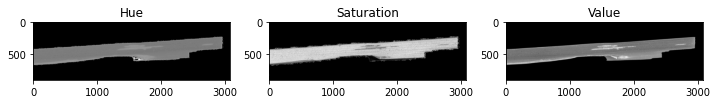

In [80]:
x = cv2.imread("rld_img_rembg/blb/DSC_0365.jpg") #read image from path
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) #convert image color to RGB
leaf_disease_hsv = rgb2hsv(x) #convert RGB image to HSV (Based on from https://mattmaulion.medium.com/color-image-segmentation-image-processing-4a04eca25c0 by Matt Maulion)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(leaf_disease_hsv[:,:,0], cmap='gray')
ax[0].set_title('Hue')
ax[1].imshow(leaf_disease_hsv[:,:,1], cmap='gray')
ax[1].set_title('Saturation')
ax[2].imshow(leaf_disease_hsv[:,:,2], cmap='gray')
ax[2].set_title('Value')


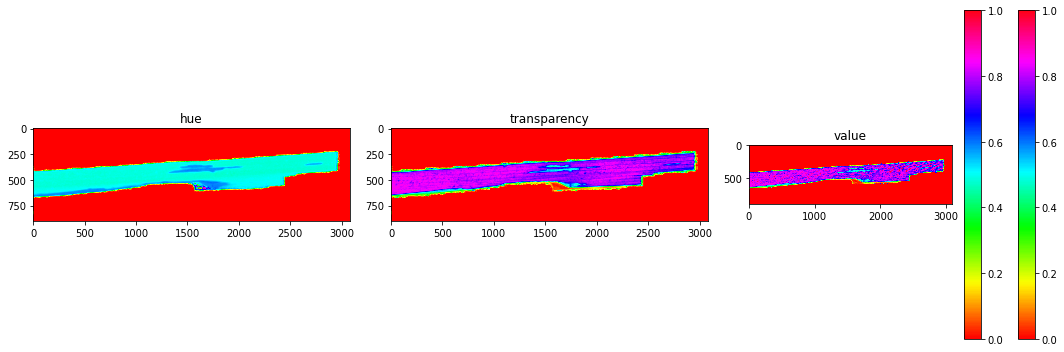

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(leaf_disease_hsv[:,:,0],cmap='hsv')
ax[0].set_title('hue')
ax[1].imshow(leaf_disease_hsv[:,:,1],cmap='hsv')
ax[1].set_title('transparency')
ax[2].imshow(leaf_disease_hsv[:,:,2],cmap='hsv')
ax[2].set_title('value')
fig.colorbar(skimage.io.imshow(leaf_disease_hsv[:,:,0],cmap='hsv')) 
fig.colorbar(skimage.io.imshow(leaf_disease_hsv[:,:,1],cmap='hsv')) 
# fig.colorbar(imshow(leaf_disease_hsv[:,:,2],cmap='hsv')) 

fig.tight_layout()


In [82]:
#lower hue 
lower_hue_mask = leaf_disease_hsv[:,:,0] > 0.487
#upper hue
upper_hue_mask = leaf_disease_hsv[:,:,0] < 0.65 
#transparensi
lower_saturation_mask = leaf_disease_hsv[:,:,1] > 0.5
upper_saturation_mask = leaf_disease_hsv[:,:,1] < 0.8

 
mask_segment = upper_hue_mask*lower_hue_mask*lower_saturation_mask*upper_saturation_mask
# red = x[:,:,0]*mask
# green = x[:,:,1]*mask
# blue = x[:,:,2]*mask
# bags_masked = np.dstack((red,green,blue))
# imshow(bags_masked)


In [8]:

# path mask
m_blb_path = "rld_mask/blb"
m_bs_path = "rld_mask/bs"
m_ls_path = "rld_mask/ls"


def create_hue_mask(path1, path2, non_target_hue, target_hue):
    """
    Create mask of images from path1 and save them to 
        path2y
    Args:
        path: path of the image folder directory in string
        path2: path of the mask image destination
        non-target-hue: hue value to be removed
        target-hue: targeted hue value 
    Returns: 
    """
    os_path = os.listdir(path1)
    for img in os_path[:]:
        read_img = np.array(Image.open(path1 + "/" + img))

        # Hue segment
        img_hue = read_img[:,:,0]
        markers = np.zeros_like(img_hue)
        if non_target_hue != None:
            markers[img_hue < non_target_hue] = 1
        if target_hue != None:
            markers[img_hue > target_hue] = 2
        cmapps = ["gray"]

        for i in range(len(cmapps)):
            plt.imsave(path2 + "/" + img, markers, cmap=str(cmapps[i])) #use colormap


def create_adp_mask(path1, path2, adp_type,  thres_type):
    """
    Create mask of images from path1 and save them to 
        path2y
    Args:
        path: path of the image folder directory in string
        path2: path of the mask image destination
        adp_type: adaptive method 
        thres_type: threshold type
    Returns: 
    """
    os_path = os.listdir(path1)
    for img in os_path[:]:
        read_img = np.array(Image.open(path1 + "/" + img))


        # adapthist thresholding
        img_gray = cv2.cvtColor(read_img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=5)
        clahe_img = clahe.apply(img_gray)
        threshG = cv2.adaptiveThreshold(clahe_img, 255, adp_type, thres_type, 199, 18)

        cv2.imwrite(path2 + "/" + img, threshG) #use colormap


        


In [21]:
# create_hue_mask(r_blb_path, m_blb_path, None, 60)
# create_adp_mask(r_bs_path, m_bs_path, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV)
create_adp_mask(r_ls_path, m_ls_path, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV)


In [19]:
# path segment img
seg_blb_path = "segment_img/blb"
seg_bs_path = "segment_img/bs"
seg_ls_path = "segment_img/ls"

def segment_disease(path_r, path_m, path_res):
    """
    Segment disease from the paddy leaf
    Args:
        path_r: path of the removed background image
        path_m: path of the mask image 
        path_res: destination path of segment image
    Returns: 
    """
    os_path = os.listdir(path_r)
    for img in os_path[:]:
        r_img = cv2.imread(path_r + "/" + img)
        r_img = cv2.cvtColor(r_img, cv2.COLOR_BGR2RGB)

        m_img = cv2.imread(path_m + "/" + img)

        res = cv2.bitwise_and(r_img, m_img)
        cv2.imwrite(path_res + "/" + img, res)

    


In [20]:
# segment_disease(r_blb_path, m_blb_path, seg_blb_path)
segment_disease(r_bs_path, m_bs_path, seg_bs_path)

In [87]:
import torch 
from torchvision import datasets, transforms, models

In [88]:
data_dir = "rice_leaf_diseases/"

train_data = datasets.ImageFolder(data_dir + '/train')
val_data = datasets.ImageFolder(data_dir + '/validation')

In [89]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data,)

dataiter = iter(train_data)
images, clases = dataiter.__next__()
print(type(images))


<class 'PIL.Image.Image'>


In [90]:
train_transforms = transforms.Compose([transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.ToTensor(),])
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [91]:
train_transforms = transforms.Compose([transforms.ToTensor()])
val_transforms = transforms.Compose([transforms.ToTensor(),])
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [92]:
import torch.nn as nn
import numpy as np
class CropDetectCNN(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(CropDetectCNN, self).__init__()
        
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2))
        
        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(kernel_size=2))
        
        #Fully connected layer
        self.fc = nn.Linear(32*28*28, 39)
         
    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
model = CropDetectCNN()
print(model)

CropDetectCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=25088, out_features=39, bias=True)
)


In [93]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [94]:
# run on GPU if available else run on a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [95]:
epochs = 1 # run more iterations
for epoch in range(epochs):
    running_loss = 0
    for images, classes in train_loader:
        # To device - to transfrom the image and classes to CPU|GPU
        images, classes = images.to(device), classes.to(device)
        
        # clears old gradients from the last step
        optimizer.zero_grad()
        
        # train the images
        outputs = model(images)
        
        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, classes)
        
        # compute the loss of every parameter
        loss.backward()
        
        # apply the optimizer and its parameters
        optimizer.step()
        
        #update the loss
        running_loss += loss.item()
        
    else:
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for images, classes in val_loader:          
                # Use GPU
                images, classes = images.to(device), classes.to(device)
                
                # validate the images
                outputs = model(images)
                
                # compute validation loss
                loss = criterion(outputs, classes)
                
                #update loss
                validation_loss += loss.item()
                
                # get the exponential of the outputs
                ps = torch.exp(outputs)
                
                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)
                
                # reshape the tensor
                equals = top_class == classes.view(*top_class.shape)
                
                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # change the mode to train for the next epochs
        model.train()
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader)))

RuntimeError: stack expects each tensor to be equal size, but got [3, 291, 741] at entry 0 and [3, 897, 3081] at entry 1